## Introduction

In this notebbok, I will explore different strategies of how tf.functions can be used to improve the training speed of custom keras models.

## Defining a custom model

At our company, we train models on examples with varying shapes. Let us define a toy custom model which can accept an input which varies in length in the first dimension. 

The model performs a reduce_max across its's dimension, and then passes it through a series of dense layers with relu activation.

In [1]:
import tensorflow as tf

class MyCustomModel(tf.keras.Model):
    def __init__(self):
        super(MyCustomModel, self).__init__()
        num_hidden_layer_units = [10, 20, 40, 20, 10]
        self.hidden_layers = [tf.keras.layers.Dense(unit, activation='relu') for unit in num_hidden_layer_units]
        self.final = tf.keras.layers.Dense(1)
    def call(self, inputs):
        net = tf.math.reduce_max(inputs, axis=1, keepdims=True)
        for layer in self.hidden_layers:
            net = layer(net)
        return self.final(net)
    
model = MyCustomModel()

In [2]:
## Define loss and optimizer
loss = tf.keras.losses.MeanSquaredError()
optimizer = optimizer=tf.keras.optimizers.Adam(0.01)

## Define the dataset

We define a generator which yields samples varying in length in the first dimension. And then create a dataset where each example is of shape (X, 20) where X can vary between 1 and 10.

In [3]:
import numpy as np

def data_gen(max_len, n_dim):
    def gen(): 
        while True:
            seq_len = np.random.randint(1, max_len+1)
            yield np.random.random((seq_len, n_dim)).astype(np.float32), np.random.random()
    return gen

In [4]:
dataset = tf.data.Dataset.from_generator(
    data_gen(10, 20),
    (tf.float32, tf.float32), 
    (tf.TensorShape([None, 20]), tf.TensorShape([]))
)
# Set batch size 1
dataset = dataset.batch(1)

## Define the training loop

In [5]:
def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        preds = model(inputs, training=True)
        loss_value = loss(preds, targets)
    grad = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grad, model.trainable_variables))

In [6]:
def train(dataset, train_step):
    for inputs, target in dataset:
        train_step(inputs, target)

## Training in eager mode

By default, tensorflow 2.1 runs everything in eager mode. Eager model is really convinient for model development, as it allows us to easily set breakpoints and step into each step of the model code. However eager mode is slow. Lets see the timings for running the training on 1000 examples.

In [7]:
train_data = dataset.take(1000)

In [8]:
%%time
train(train_data, train_step)

CPU times: user 8.52 s, sys: 273 ms, total: 8.8 s
Wall time: 8.44 s


## Training with tf function

Tf function provides the functionality of converting a python function automatically into a tensorflow graph which can then be executed efficiently by the tensorflow runtime.

First we convert the `train_step` function into a tf function.

In [9]:
tf_train_step = tf.function(train_step)

In [10]:
%%time
train(train_data, tf_train_step)

CPU times: user 2.7 s, sys: 503 ms, total: 3.2 s
Wall time: 2.37 s


We notice that the time taken improves drastically from 8.44 sec to 2.25 secs. We also notice a bunch of warnings from tensorflow about retracing.

Retracing happens because the shape of the examples are not the same. Whenever the function encounters a shape that it has not seen below, it will compile a new graph for that shape. Compiling a new graph is expensive. In our case, the dataset can have 10 different shapes, so the retracing operation will happen upto 10 times.

## Training with tf function with signatures

To avoid retracing for each new shape, we can provide an input signature for the tf function. The dimensions which vary can be indicated with a `None`.

In [11]:
tf_train_step_signature = tf.function(
    train_step,
    input_signature=[
        tf.TensorSpec(shape=(None, None, 20), dtype=tf.float32), 
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    ]
)

In [12]:
%%time
train(train_data, tf_train_step_signature)

CPU times: user 1.27 s, sys: 453 ms, total: 1.72 s
Wall time: 904 ms


## Comparing tf functions with and without signature

Using a signature avoids the retracing and the training time improved further from 2.25s to 1.11s . Before deciding that using a signature is better, let us perform the training with more examples and add some instrumentation.

In [13]:
train_data_large = dataset.take(20000)

In [14]:
from time import time

def timer(f, timings):
    def wraps(*args, **kwargs):
        st = time()
        res = f(*args, **kwargs)
        en = time()
        timings.append(en-st)
    return wraps

In [15]:
timings_tf = []
tf_train_step = timer(tf.function(train_step), timings_tf)

In [16]:
%%time
train(train_data_large, tf_train_step)

CPU times: user 17.9 s, sys: 8.43 s, total: 26.3 s
Wall time: 12 s


In [17]:
timings_tf_signature = []
tf_train_step_signature = timer(
    tf.function(
        train_step,
        input_signature=[
            tf.TensorSpec(shape=(None, None, 20), dtype=tf.float32), 
            tf.TensorSpec(shape=(None,), dtype=tf.float32)
        ]
    ),
    timings_tf_signature
)

In [18]:
%%time
train(train_data_large, tf_train_step_signature)

CPU times: user 19.5 s, sys: 8.59 s, total: 28.1 s
Wall time: 14 s


So as it turned out, in the long run the tf function without signature was faster than tf function with signature. Plotting the timings will make it clear why this happens. 

In [19]:
from matplotlib.pylab import plt

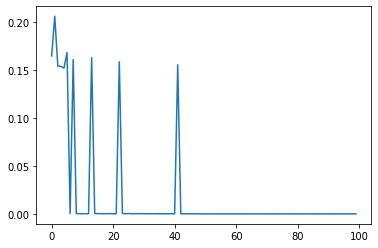

In [20]:
plt.plot(timings_tf[0:100])

The graph plots the time to run each train step. There are some initial spikes in the plot. The spikes happen whenever a expensive retracing of the graph occurs. But once all the possible shapes in the data is encountered, there are no further retracing.

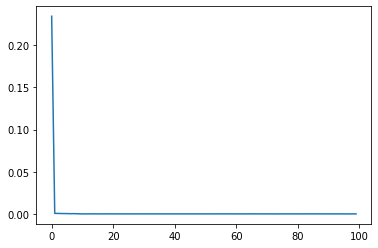

In [21]:
plt.plot(timings_tf_signature[0:100])

For the graph of tf function with signature, retracing does not happen, so after the initial first expensive step when the graph is constructed, the rest of the steps take the same amount of time.

So let us know now compare the time needed to run a single step between the two cases, discarding all the retracing operations.

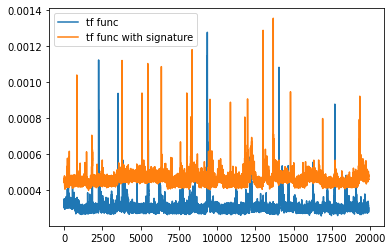

In [22]:
plt.ioff()
plt.plot(timings_tf[100:], label="tf func")
plt.plot(timings_tf_signature[100:], label="tf func with signature")
plt.legend(loc="upper left")
plt.show()

The plot shows clearly that indeed the tf function with signature is slower.

## In-graph training loop

It is also possible to wrap the entire `train` function as a tf function. In this case, the entire training including the dataset iteration happens within the compiled tensorflow graph.

In [23]:
tf_train = tf.function(train)

In [24]:
%%time
tf_train(train_data_large, train_step)

CPU times: user 14.7 s, sys: 8.42 s, total: 23.1 s
Wall time: 8.09 s


## Conclusion

By default tensorflow 2.1 runs in eager mode which is useful for development and debugging. Performance can be boosted by wrapping your functions in `tf.function` which compiles a tensorflow graph which the framework can execute efficiently.

There are several ways to wrap portions of your code as a `tf.function` . In the demonstrated toy example, the best performance was observed with the case when the entire training happened inside a tf.function.

However in real world use case there are several factors at play - whether all of the dataset is in memory or streamed from disk / network , computational load of the model, whether gpu / multiple gpus are being used, how the shapes of your training data varies etc. One should experiment to figure how the `tf.function` can be used most efficiently.
